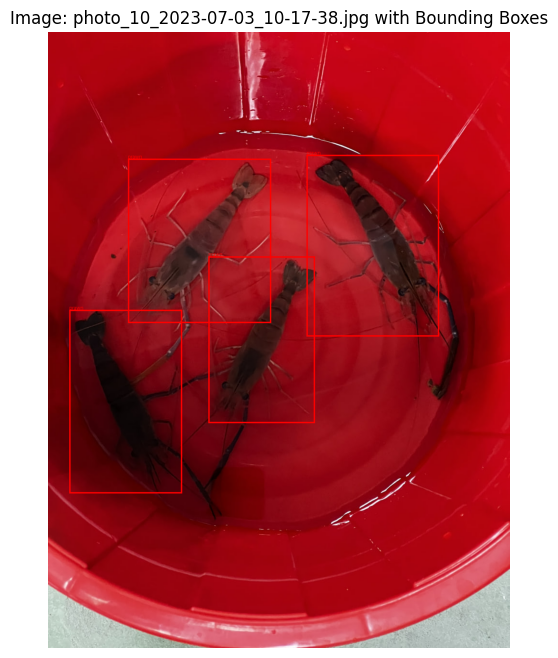

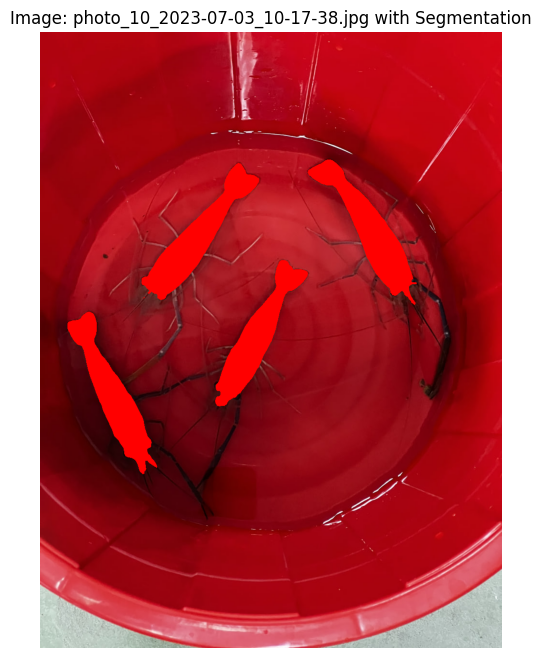

In [26]:
import os
import random
from pathlib import Path
import xml.etree.ElementTree as ET
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import torch
import numpy as np
from segment_anything import SamPredictor, sam_model_registry
from torchvision.transforms.functional import to_tensor, to_pil_image


class SAMHandler:
    def __init__(self, model_type="vit_h", checkpoint_path="", device=None):
        """
        Initializes the SAMHandler with the specified model type and checkpoint.
        :param model_type: Type of SAM model to load (e.g., 'vit_b', 'vit_l', 'vit_h')
        :param checkpoint_path: Path to the SAM model checkpoint
        :param device: 'cuda' or 'cpu', automatically detected if not specified
        """
        self.model_type = model_type
        self.checkpoint_path = checkpoint_path
        self.device = device or ("cuda" if torch.cuda.is_available() else "cpu")
        self.sam_model = None
        self.predictor = None
        self._load_model()

    def _load_model(self):
        """Loads the SAM model and sets up the predictor."""
        if not self.checkpoint_path:
            raise ValueError("Checkpoint path is required to load the SAM model.")
        self.sam_model = sam_model_registry[self.model_type](checkpoint=self.checkpoint_path)
        self.sam_model.to(device=self.device)
        self.predictor = SamPredictor(self.sam_model)

    def segment_image(self, image_path, bboxes):
        """
        Segments objects in an image based on bounding boxes using SAM.
        :param image_path: Path to the image
        :param bboxes: List of bounding boxes [{xmin, ymin, xmax, ymax}]
        :return: PIL image with segmentation masks overlayed
        """
        with Image.open(image_path) as img:
            img_tensor = to_tensor(img).unsqueeze(0).to(self.device)
            img_array = img_tensor.squeeze(0).permute(1, 2, 0).cpu().numpy()
            self.predictor.set_image(img_array)

            masks = []
            for bbox in bboxes:
                input_box = np.array(
                    [bbox["xmin"], bbox["ymin"], bbox["xmax"], bbox["ymax"]]
                ).reshape(1, -1)
                mask, _, _ = self.predictor.predict(box=input_box)
                masks.append(mask[0])  # Extract the mask for each bounding box

            # Overlay masks on the image
            overlay_image = img_tensor.squeeze(0).clone().permute(1, 2, 0).cpu()  # [H, W, C]
            for mask in masks:
                expanded_mask = torch.tensor(mask)  # [H, W]
                # Ensure the mask has the same number of dimensions as the image
                mask_bool = expanded_mask > 0.5  # Boolean mask
                # Add a channel dimension to the mask for broadcasting
                mask_bool = mask_bool.unsqueeze(-1)  # [H, W, 1]
                # Apply red color to the masked regions
                overlay_image = torch.where(mask_bool, torch.tensor([1.0, 0.0, 0.0]), overlay_image)
            overlay_image = overlay_image.permute(2, 0, 1)  # [C, H, W]
            return to_pil_image(overlay_image)

# Paths and setup
project_root = Path(os.getcwd()).parent
test_path = project_root / "data/prawns/test"

# Initialize SAM
MODEL_TYPE = "vit_h"  # Choose your SAM model type
CHECKPOINT_PATH = "../checkpoints/sam_vit_h_4b8939.pth"  # Update this path
sam_handler = SAMHandler(model_type=MODEL_TYPE, checkpoint_path=CHECKPOINT_PATH)

# Get all image and annotation files
image_files = list(test_path.glob("*.jpg")) + list(test_path.glob("*.png"))
annotation_files = list(test_path.glob("*.xml"))

# Function to parse XML and extract bounding box information
def parse_annotations(annotation_path):
    tree = ET.parse(annotation_path)
    root = tree.getroot()
    bboxes = []
    for obj in root.findall("object"):
        name = obj.find("name").text
        bndbox = obj.find("bndbox")
        bbox = {
            "name": name,
            "xmin": int(bndbox.find("xmin").text),
            "ymin": int(bndbox.find("ymin").text),
            "xmax": int(bndbox.find("xmax").text),
            "ymax": int(bndbox.find("ymax").text),
        }
        bboxes.append(bbox)
    return bboxes

# Function to draw bounding boxes on image
def draw_bounding_boxes(image_path, bboxes):
    with Image.open(image_path) as img:
        draw = ImageDraw.Draw(img)
        for bbox in bboxes:
            draw.rectangle(
                [(bbox["xmin"], bbox["ymin"]), (bbox["xmax"], bbox["ymax"])],
                outline="red",
                width=3,
            )
            # Add label text above the box
            text_position = (bbox["xmin"], bbox["ymin"] - 10)
            draw.text(text_position, bbox["name"], fill="red")
        return img

# Display random image with bounding boxes and segmentation
def display_random_image_with_bbox_and_segmentation():
    if not image_files or not annotation_files:
        print("No images or annotations found!")
        return

    # Select a random image and its corresponding annotation
    random_image_path = random.choice(image_files)
    annotation_path = test_path / (random_image_path.stem + ".xml")

    if not annotation_path.exists():
        print(f"No annotation file found for {random_image_path.name}")
        return

    # Parse annotations
    bboxes = parse_annotations(annotation_path)

    # Display bounding boxes
    image_with_bboxes = draw_bounding_boxes(random_image_path, bboxes)
    plt.figure(figsize=(8, 8))
    plt.imshow(image_with_bboxes)
    plt.axis("off")
    plt.title(f"Image: {random_image_path.name} with Bounding Boxes")
    plt.show()

    # Perform SAM segmentation
    formatted_bboxes = [{"xmin": bbox["xmin"], "ymin": bbox["ymin"], "xmax": bbox["xmax"], "ymax": bbox["ymax"]} for bbox in bboxes]
    segmented_image = sam_handler.segment_image(random_image_path, formatted_bboxes)
    plt.figure(figsize=(8, 8))
    plt.imshow(segmented_image)
    plt.axis("off")
    plt.title(f"Image: {random_image_path.name} with Segmentation")
    plt.show()


# Run the function
display_random_image_with_bbox_and_segmentation()